In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Filtrado del DataFrame

##### El archivo utilizado en este notebook se puede conseguir en properati.com/data con el nombre:
    properati-AR-2017-08-01-properties-sell.csv
##### Para ejecutar el análisis, importar el archivo en la carpeta del notebook

In [2]:
property_data = pd.read_csv('properati-AR-2017-08-01-properties-sell.csv')

In [3]:
property_data = property_data[property_data.place_with_parent_names.str.contains('Capital Federal') | 
                            property_data.place_with_parent_names.str.contains('Bs.As. G.B.A.')]

In [4]:
init_data = property_data[['created_on', 'property_type', 'price_aprox_usd', 'surface_total_in_m2',\
                           'surface_covered_in_m2', 'price_usd_per_m2']]

In [5]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124746 entries, 0 to 187480
Data columns (total 6 columns):
created_on               124746 non-null object
property_type            124746 non-null object
price_aprox_usd          110203 non-null float64
surface_total_in_m2      89385 non-null float64
surface_covered_in_m2    109180 non-null float64
price_usd_per_m2         79108 non-null float64
dtypes: float64(4), object(2)
memory usage: 6.7+ MB


In [6]:
init_data.columns = ['date', 'type', 'total_price', 'total_surface', 'covered_surface', 'm2_price']
init_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124746 entries, 0 to 187480
Data columns (total 6 columns):
date               124746 non-null object
type               124746 non-null object
total_price        110203 non-null float64
total_surface      89385 non-null float64
covered_surface    109180 non-null float64
m2_price           79108 non-null float64
dtypes: float64(4), object(2)
memory usage: 6.7+ MB


In [7]:
def set_surface(row):
    total = row.total_surface
    covered = row.covered_surface
    if np.isnan(total):
        row.total_surface = covered
        return row
    return row

In [8]:
surface_data = init_data.apply(set_surface, axis = 1)

In [9]:
filled_data = surface_data[['date', 'type', 'total_price', 'total_surface', 'm2_price']]

In [10]:
useful_data = filled_data[(filled_data.m2_price > 0) | ((filled_data.total_price > 0) & (filled_data.total_surface > 0))]

In [11]:
def set_m2_price(row):
    price = row.total_price
    surface = row.total_surface
    if np.isnan(row.m2_price):
        row.m2_price = price/surface
        return row
    return row

In [12]:
complete_data = useful_data.apply(set_m2_price, axis = 1)
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103158 entries, 0 to 187480
Data columns (total 5 columns):
date             103158 non-null object
type             103158 non-null object
total_price      103158 non-null float64
total_surface    103158 non-null float64
m2_price         103158 non-null float64
dtypes: float64(3), object(2)
memory usage: 4.7+ MB


In [13]:
complete_data.dropna(inplace = True)
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103158 entries, 0 to 187480
Data columns (total 5 columns):
date             103158 non-null object
type             103158 non-null object
total_price      103158 non-null float64
total_surface    103158 non-null float64
m2_price         103158 non-null float64
dtypes: float64(3), object(2)
memory usage: 4.7+ MB


# Análisis

## Variación del precio por $m^2$ a través de los años

In [14]:
#Le agrego una columna que es el año
complete_data['year'] = complete_data['date']
complete_data['year'] = complete_data['year'].apply(lambda x: int(x[0:4]))

#Le agrego una columna que es el mes
complete_data['month'] = complete_data['date']
complete_data['month'] = complete_data['month'].apply(lambda x: int(x[5:7]))

In [15]:
price_year = complete_data[['year', 'm2_price']]
by_year_raw = price_year.groupby('year').agg([np.mean, np.size])
by_year_raw

m2_price         
             mean     size
year                      
2012   659.009009      3.0
2013  1543.249693    322.0
2014  1415.337828   3006.0
2015  1885.789439   7609.0
2016  2355.716581  20278.0
2017  2944.811643  71940.0

#### Eliminamos el año 2012 porque solo tiene 3 propiedades

In [16]:
by_year = by_year_raw[1:]
by_year

m2_price         
             mean     size
year                      
2013  1543.249693    322.0
2014  1415.337828   3006.0
2015  1885.789439   7609.0
2016  2355.716581  20278.0
2017  2944.811643  71940.0

### General

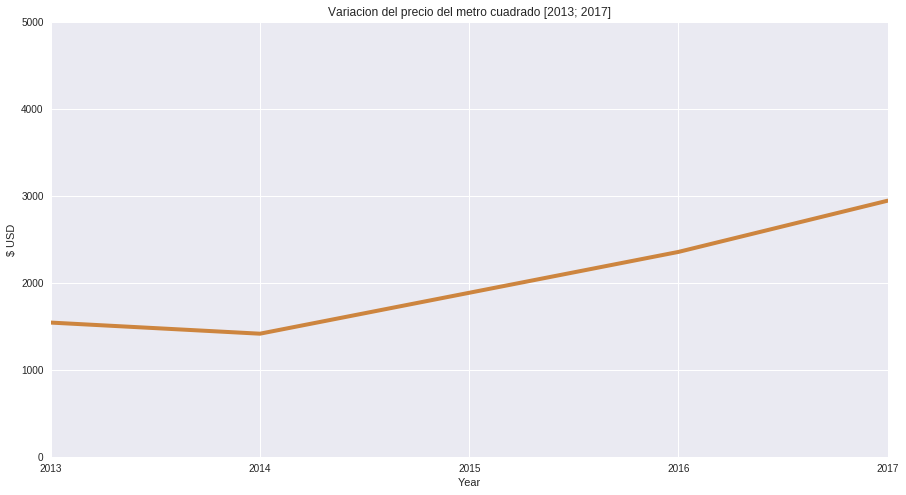

In [17]:
l = [2013, 2014, 2015, 2016, 2017]
ax = by_year.plot(kind='line', y = ('m2_price', 'mean'), figsize=(15,8),\
             title = "Variacion del precio del metro cuadrado [2013; 2017]",\
             xticks=l, legend = False, color = 'peru', lw = 4)
ax.set_ylabel('$ USD')
ax.set_xlabel('Year')
ax.set_ylim([0,5000])

plt.show()

### Año por año

#### 2013

In [18]:
year_2013 = complete_data[complete_data['year'] == 2013]
year_2013.head()

,date,type,total_price,total_surface,m2_price,year,month
5,2013-01-04,apartment,97000.0,54.0,1796.296296,2013,1
10,2013-01-26,apartment,100000.0,45.0,2222.222222,2013,1
12,2013-02-08,house,390000.0,375.0,1040.000000,2013,2
13,2013-02-15,apartment,275000.0,111.0,2477.477477,2013,2
29,2013-03-23,apartment,88000.0,60.0,1466.666667,2013,3


In [19]:
month_data_2013 = year_2013[['m2_price', 'month']]
by_month_2013 = month_data_2013.groupby('month').agg([np.mean, np.size])
by_month_2013

m2_price       
              mean   size
month                    
1      2009.259259    2.0
2      1758.738739    2.0
3      1546.183107    7.0
4      1572.680364    3.0
5      1563.348647  197.0
6      1870.308556   17.0
7      1721.744011   24.0
8      1380.020743   19.0
9      1104.554358    9.0
10     1489.266864   16.0
11     1323.973021   19.0
12     1086.736676    7.0

###### Se debe decir que no puede ser muy representativo porque la mayoria de los meses tienen menos de 10 propiedades 

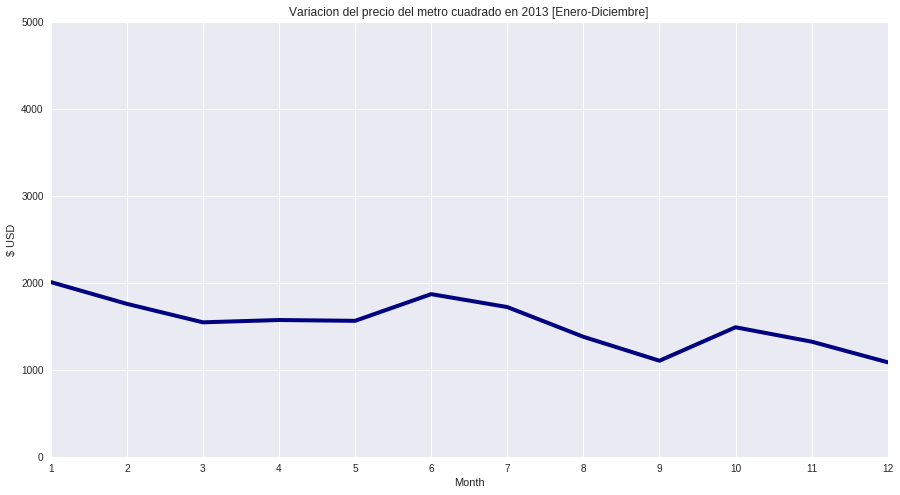

In [20]:
l = [x for x in xrange(1, 13)]
ax = by_month_2013.plot(kind='line', y = ('m2_price', 'mean'), figsize=(15,8),\
             title = "Variacion del precio del metro cuadrado en 2013 [Enero-Diciembre]",\
             xticks=l, legend = False, color = 'navy', lw = 4)
ax.set_ylabel('$ USD')
ax.set_xlabel('Month')
ax.set_ylim([0,5000])

plt.show()

#### 2014

In [21]:
year_2014 = complete_data[complete_data['year'] == 2014]
year_2014.head()

,date,type,total_price,total_surface,m2_price,year,month
926,2014-01-09,house,170000.0,1600.0,106.250000,2014,1
927,2014-01-09,house,300000.0,820.0,365.853659,2014,1
928,2014-01-09,house,83000.0,85.0,976.470588,2014,1
944,2014-01-13,PH,550000.0,139.0,3956.834532,2014,1
945,2014-01-13,store,180000.0,300.0,600.000000,2014,1


In [22]:
month_data_2014 = year_2014[['m2_price', 'month']]
by_month_2014 = month_data_2014.groupby('month').agg([np.mean, np.size])
by_month_2014

m2_price        
              mean    size
month                     
1      1451.363775    33.0
2      3619.342500    10.0
3      1286.104253  1508.0
4      2349.337325   107.0
5      1547.252945   104.0
6      1314.330337   393.0
7      1393.214939   118.0
8      1421.850694    99.0
9      1578.633114   124.0
10     1253.696123   134.0
11     1742.691994   293.0
12     1477.464130    83.0

###### Ahora hay un poco mas de información pero hay un mes (Febrero) donde son muy pocas las propiedades

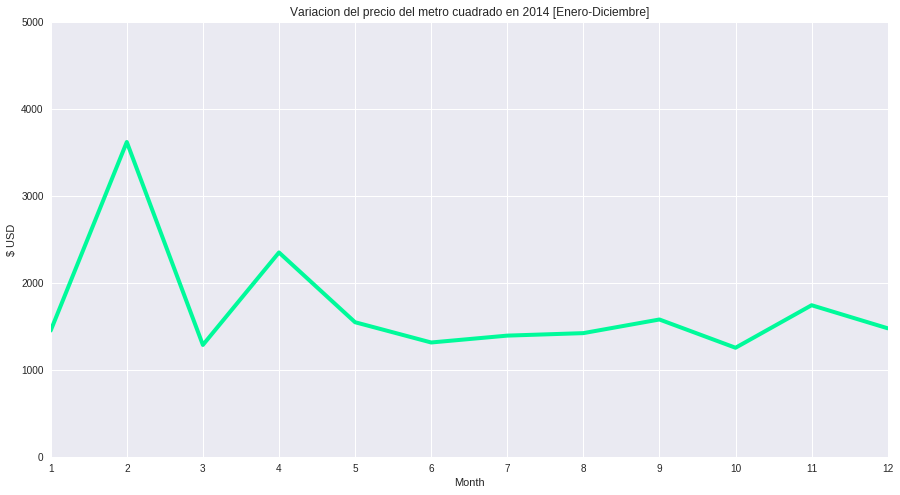

In [23]:
l = [x for x in xrange(1, 13)]
ax = by_month_2014.plot(kind='line', y = ('m2_price', 'mean'), figsize=(15,8),\
             title = "Variacion del precio del metro cuadrado en 2014 [Enero-Diciembre]",\
             xticks=l, legend = False, color = 'mediumspringgreen', lw = 4)
ax.set_ylabel('$ USD')
ax.set_xlabel('Month')
ax.set_ylim([0,5000])

plt.show()

#### 2015

In [24]:
year_2015 = complete_data[complete_data['year'] == 2015]
year_2015.head()

,date,type,total_price,total_surface,m2_price,year,month
8062,2015-01-01,house,165000.0,150.0,1100.000000,2015,1
8067,2015-01-02,house,750000.0,850.0,882.352941,2015,1
8071,2015-01-02,house,150000.0,280.0,535.714286,2015,1
8077,2015-01-03,apartment,60000.0,65.0,923.076923,2015,1
8078,2015-01-03,house,160000.0,240.0,666.666667,2015,1


In [25]:
month_data_2015 = year_2015[['m2_price', 'month']]
by_month_2015 = month_data_2015.groupby('month').agg([np.mean, np.size])
by_month_2015

m2_price        
              mean    size
month                     
1      2552.306812   286.0
2      1621.961891   195.0
3      1443.190594  1366.0
4      2031.517281   504.0
5      2526.091950   417.0
6      2187.486562   324.0
7      2121.125589  1765.0
8      1657.201169   426.0
9      1674.479230   617.0
10     1700.958941   780.0
11     1670.704638   489.0
12     2087.931552   440.0

###### Ahora ya tenemos una buena cantidad de propiedades para todos los meses

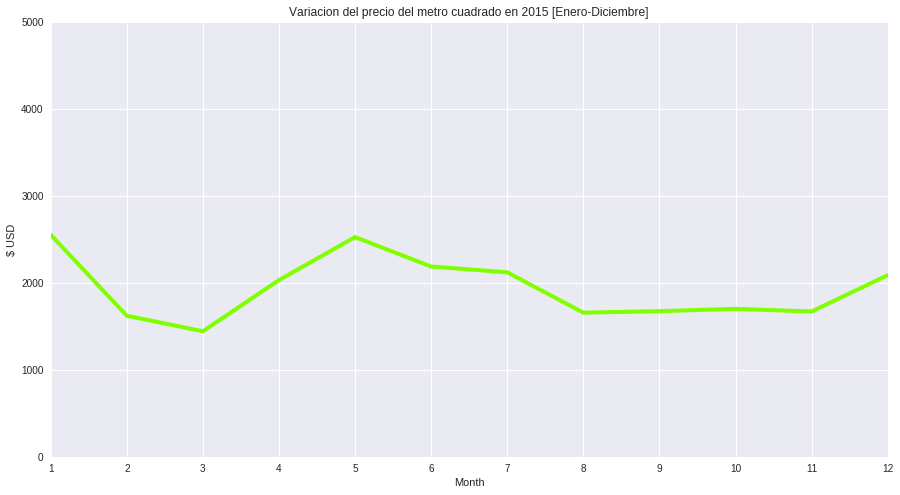

In [26]:
l = [x for x in xrange(1, 13)]
ax = by_month_2015.plot(kind='line', y = ('m2_price', 'mean'), figsize=(15,8),\
             title = "Variacion del precio del metro cuadrado en 2015 [Enero-Diciembre]",\
             xticks=l, legend = False, color = 'chartreuse', lw = 4)
ax.set_ylabel('$ USD')
ax.set_xlabel('Month')
ax.set_ylim([0,5000])

plt.show()

#### 2016

In [27]:
year_2016 = complete_data[complete_data['year'] == 2016]
year_2016.head()

,date,type,total_price,total_surface,m2_price,year,month
22572,2016-01-04,apartment,77000.0,38.0,2026.315789,2016,1
22573,2016-01-04,house,470000.0,1208.0,389.072848,2016,1
22574,2016-01-05,apartment,1250000.0,188.0,6648.936170,2016,1
22575,2016-01-05,apartment,380000.0,128.0,2968.750000,2016,1
22576,2016-01-05,apartment,380000.0,128.0,2968.750000,2016,1


In [28]:
month_data_2016 = year_2016[['m2_price', 'month']]
by_month_2016 = month_data_2016.groupby('month').agg([np.mean, np.size])
by_month_2016

m2_price        
              mean    size
month                     
1      1992.618889   539.0
2      1619.149290   506.0
3      1829.413016   942.0
4      3194.014806  1097.0
5      1742.296389  1141.0
6      1968.151492  1404.0
7      1938.372898  1753.0
8      2658.260020  1811.0
9      2390.018471  1531.0
10     1889.119528  2512.0
11     2321.169328  3592.0
12     3171.947881  3450.0

###### Ahora ya tenemos una buena cantidad de propiedades para todos los meses

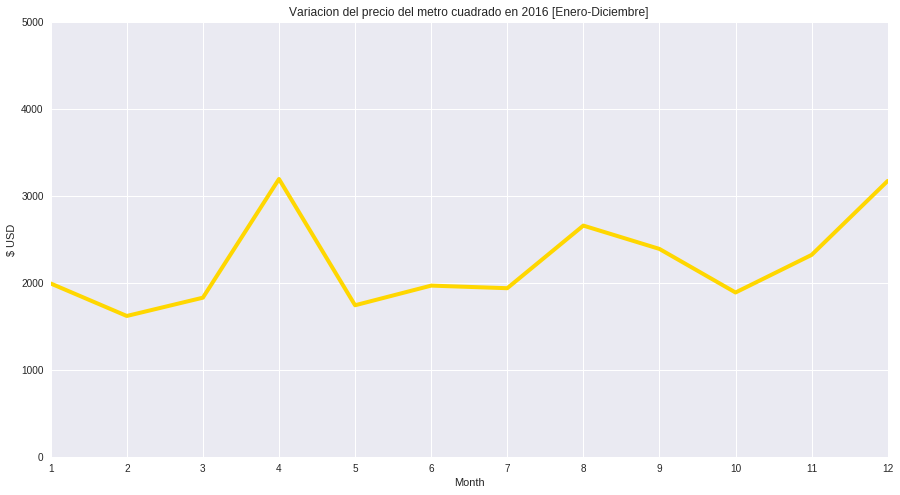

In [29]:
l = [x for x in xrange(1, 13)]
ax = by_month_2016.plot(kind='line', y = ('m2_price', 'mean'), figsize=(15,8),\
             title = "Variacion del precio del metro cuadrado en 2016 [Enero-Diciembre]",\
             xticks=l, legend = False, color = 'gold', lw = 4)
ax.set_ylabel('$ USD')
ax.set_xlabel('Month')
ax.set_ylim([0,5000])

plt.show()

#### 2017

In [30]:
year_2017 = complete_data[complete_data['year'] == 2017]
year_2017.head()

,date,type,total_price,total_surface,m2_price,year,month
60118,2017-01-01,apartment,80000.0,47.0,1702.12766,2017,1
60119,2017-01-01,store,200000.0,20.0,10000.00000,2017,1
60120,2017-01-01,apartment,90000.0,45.0,2000.00000,2017,1
60121,2017-01-01,apartment,105000.0,60.0,1750.00000,2017,1
60122,2017-01-01,apartment,140000.0,80.0,1750.00000,2017,1


In [31]:
month_data_2017 = year_2017[['m2_price', 'month']]
by_month_2017 = month_data_2017.groupby('month').agg([np.mean, np.size])
by_month_2017

m2_price         
              mean     size
month                      
1      1912.816609   3202.0
2      3016.092404   3675.0
3      2666.637306   4397.0
4      4492.004408   7055.0
5      2900.245144   7612.0
6      2680.776405   8326.0
7      2838.283377  37510.0
8      2231.018918    163.0

###### Ahora ya tenemos una buena cantidad de propiedades para todos los meses

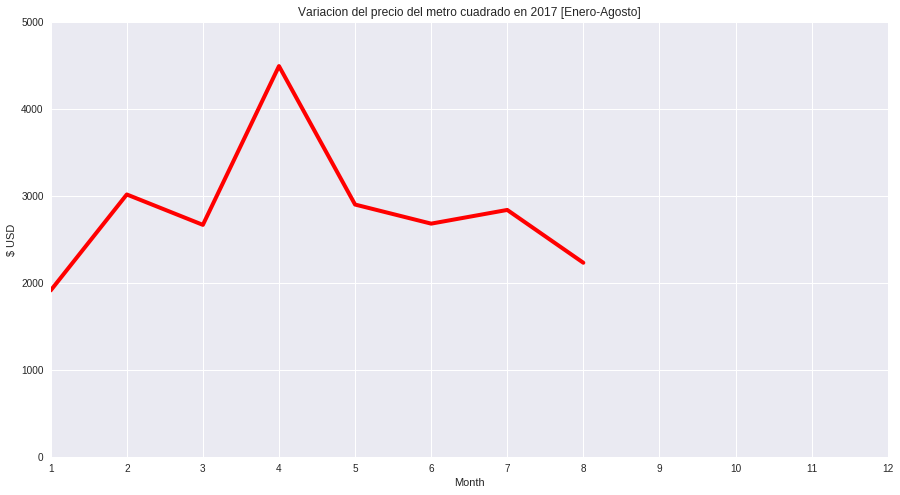

In [32]:
l = [x for x in xrange(1, 13)]
ax = by_month_2017.plot(kind='line', y = ('m2_price', 'mean'), figsize=(15,8),\
             title = "Variacion del precio del metro cuadrado en 2017 [Enero-Agosto]",\
             xticks=l, legend = False, color = 'red', lw = 4)
ax.set_ylabel('$ USD')
ax.set_xlabel('Month')
ax.set_ylim([0,5000])

plt.show()

### Grafico comparativo: progresión en cada año

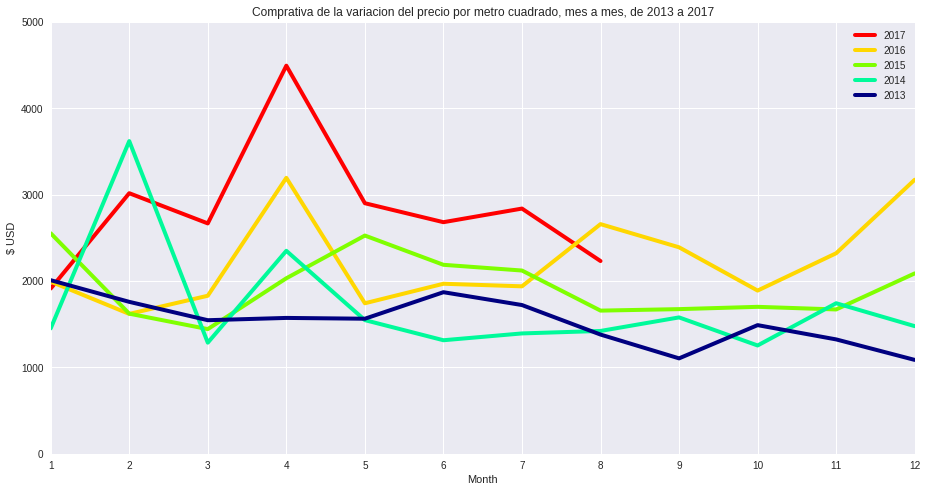

In [33]:
fig = plt.figure(figsize=(12, 6));

ax = fig.add_axes([0,0,1,1]);

by_month_2017['m2_price', 'mean'].plot.line(c='red', label="2017", xticks = [i for i in xrange(1, 13)], lw = 4);
by_month_2016['m2_price', 'mean'].plot.line(c='gold', label="2016", lw = 4);
by_month_2015['m2_price', 'mean'].plot.line(c='chartreuse', label="2015", lw = 4);
by_month_2014['m2_price', 'mean'].plot.line(c='mediumspringgreen', label="2014", lw = 4);
by_month_2013['m2_price', 'mean'].plot.line(c='navy', label="2013", lw = 4);

plt.title("Comprativa de la variacion del precio por metro cuadrado, mes a mes, de 2013 a 2017")
ax.set_ylim([0,5000])
ax.set_xlim([1, 12])
ax.set_ylabel('$ USD')
ax.set_xlabel('Month')

ax.legend();

### Grafico de barras para ver si es mas entendible o no

In [34]:
y_17 = month_data_2017.groupby('month').agg(np.mean)
y_16 = month_data_2016.groupby('month').agg(np.mean)
y_15 = month_data_2015.groupby('month').agg(np.mean)
y_14 = month_data_2014.groupby('month').agg(np.mean)
y_13 = month_data_2013.groupby('month').agg(np.mean)

In [35]:
anualProm = y_13
anualProm.columns = ['2013']
anualProm['2014'] = y_14
anualProm['2015'] = y_15
anualProm['2016'] = y_16
anualProm['2017'] = y_17

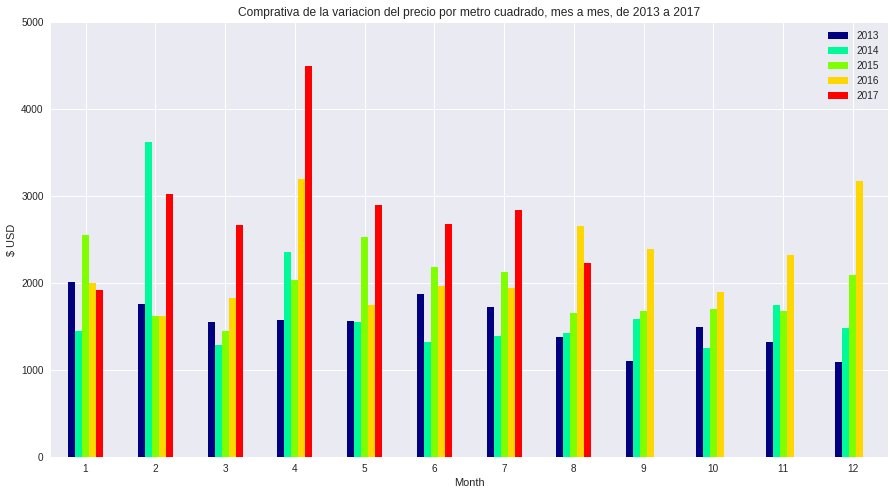

In [36]:
fig = plt.figure(figsize=(12, 6));

ax = anualProm.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12),\
                   color = ['navy', 'mediumspringgreen', 'chartreuse', 'gold', 'red'], rot = 0)

plt.title("Comprativa de la variacion del precio por metro cuadrado, mes a mes, de 2013 a 2017")
ax.set_ylim([0,5000])
ax.set_ylabel('$ USD')
ax.set_xlabel('Month')

ax.legend();

## Variación del precio por $m^2$ para cada tipo de propiedad

### Arrancamos viendo cual es el tipo de propiedad más cara  en cada año

In [37]:
price_by_type = complete_data[['type', 'm2_price', 'year']].groupby(['type', 'year']).agg([np.mean, np.size])
price_by_type.columns = ['avg_price', 'count']
price_by_type.sort_values('avg_price', ascending = False)

avg_price    count
type      year                      
store     2017  6529.084825   2380.0
          2015  3653.601389    256.0
          2016  3410.808170    732.0
apartment 2017  3092.455780  42370.0
PH        2016  2956.107738   1043.0
apartment 2016  2735.265909  11112.0
store     2014  2610.832091    141.0
apartment 2015  2597.278122   3682.0
PH        2017  2585.146306   4106.0
house     2017  2368.244914  23084.0
apartment 2013  2261.757660    139.0
          2014  1890.248160   1312.0
PH        2013  1634.962641     25.0
house     2016  1595.861738   7391.0
store     2013  1304.609637      7.0
PH        2015  1202.420944    508.0
          2014  1095.142373    245.0
house     2015  1024.230793   3163.0
          2013   877.720219    151.0
          2014   870.078531   1308.0
          2012   659.009009      3.0

#### Vemos año a año cual fue la mas cara y de cual hubo mas

#### 2017

In [38]:
grouped = price_by_type.reset_index()
average_17 = grouped[grouped.year == 2017]
average_17

,type,year,avg_price,count
4,PH,2017,2585.146306,4106.0
9,apartment,2017,3092.455780,42370.0
15,house,2017,2368.244914,23084.0
20,store,2017,6529.084825,2380.0


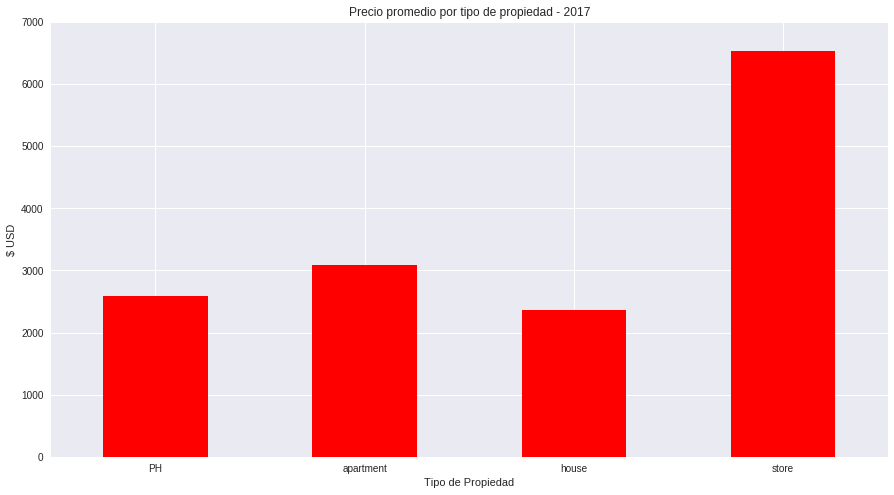

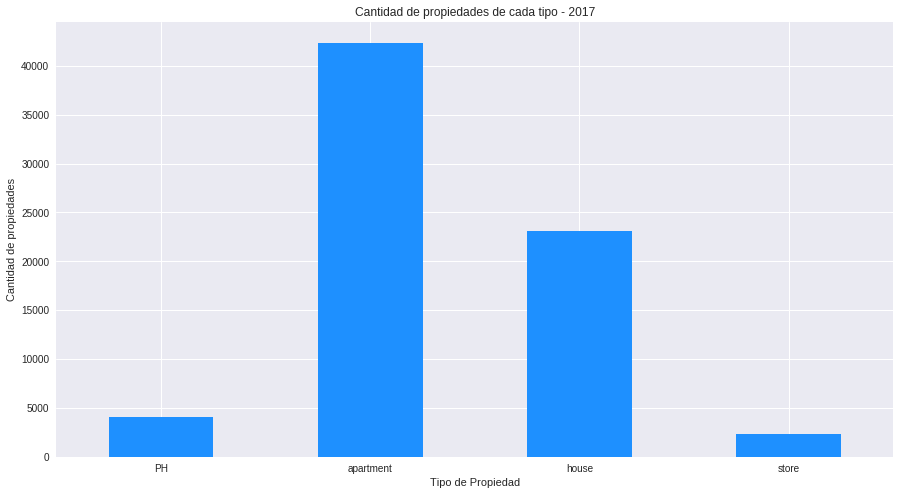

In [39]:
fig = plt.figure(figsize=(12, 6));

ax = average_17.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12), y = 'avg_price',\
                     title = "Precio promedio por tipo de propiedad - 2017",\
                     x = 'type', color = 'red', rot = 0, legend = False)
ax2 = average_17.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12), y = 'count',\
                      title = "Cantidad de propiedades de cada tipo - 2017",\
                      x = 'type', color = 'dodgerblue', rot = 0, legend = False)
ax2.set_ylabel("Cantidad de propiedades")
ax2.set_xlabel("Tipo de Propiedad")

ax.set_ylim([0,7000])
ax.set_ylabel('$ USD')
ax.set_xlabel('Tipo de Propiedad')

##### En 2017 se ve una gran predominancia de los negocios, mientras que segundo estan los departamentos y finalmente los PHs y las casas con valores similares

#### 2016

In [40]:
grouped = price_by_type.reset_index()
average_16 = grouped[grouped.year == 2016]
average_16

,type,year,avg_price,count
3,PH,2016,2956.107738,1043.0
8,apartment,2016,2735.265909,11112.0
14,house,2016,1595.861738,7391.0
19,store,2016,3410.808170,732.0


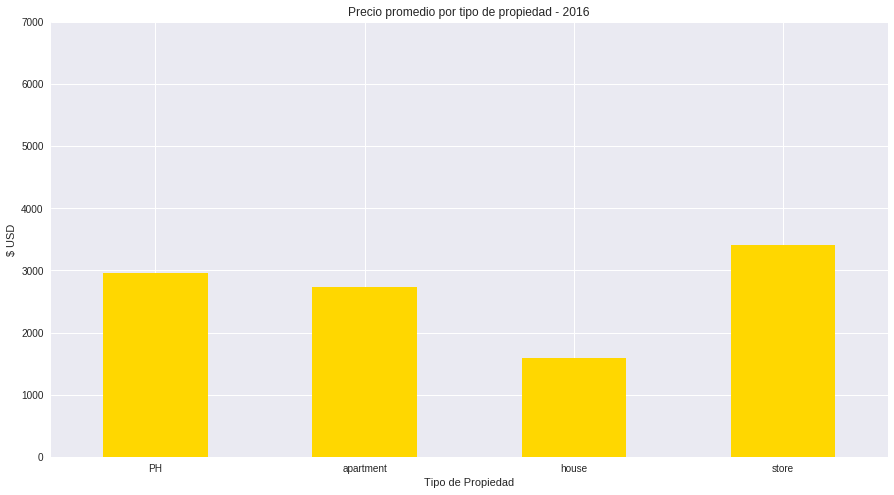

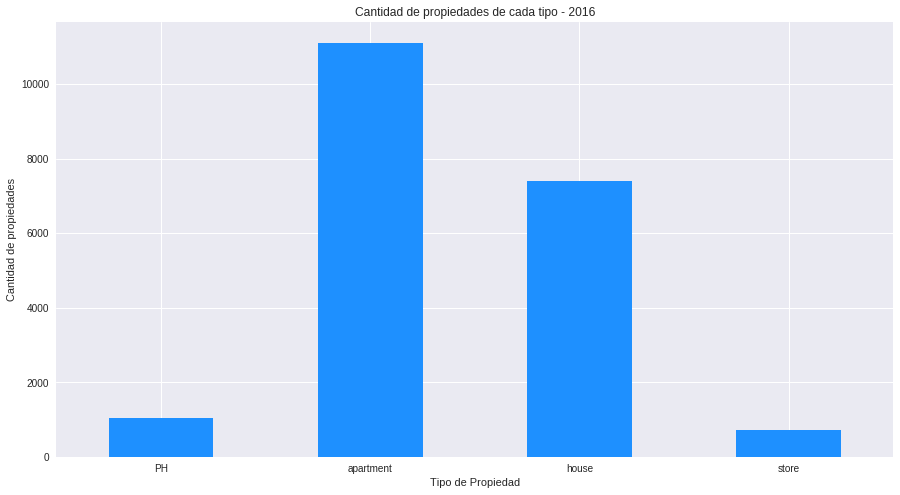

In [41]:
fig = plt.figure(figsize=(12, 6));

ax = average_16.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12), y = 'avg_price',\
                     title = "Precio promedio por tipo de propiedad - 2016",\
                     x = 'type', color = 'gold', rot = 0, legend = False)
ax2 = average_16.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12), y = 'count',\
                      title = "Cantidad de propiedades de cada tipo - 2016",\
                      x = 'type', color = 'dodgerblue', rot = 0, legend = False)
ax2.set_ylabel("Cantidad de propiedades")
ax2.set_xlabel("Tipo de Propiedad")

ax.set_ylim([0,7000])
ax.set_ylabel('$ USD')
ax.set_xlabel('Tipo de Propiedad')

##### En este caso, vemos que el precio de los negocios baja drásticamente, el de los PHs sube y las casas y los departamentos tienen un decrecimiento similar

#### 2015

In [42]:
grouped = price_by_type.reset_index()
average_15 = grouped[grouped.year == 2015]
average_15

,type,year,avg_price,count
2,PH,2015,1202.420944,508.0
7,apartment,2015,2597.278122,3682.0
13,house,2015,1024.230793,3163.0
18,store,2015,3653.601389,256.0


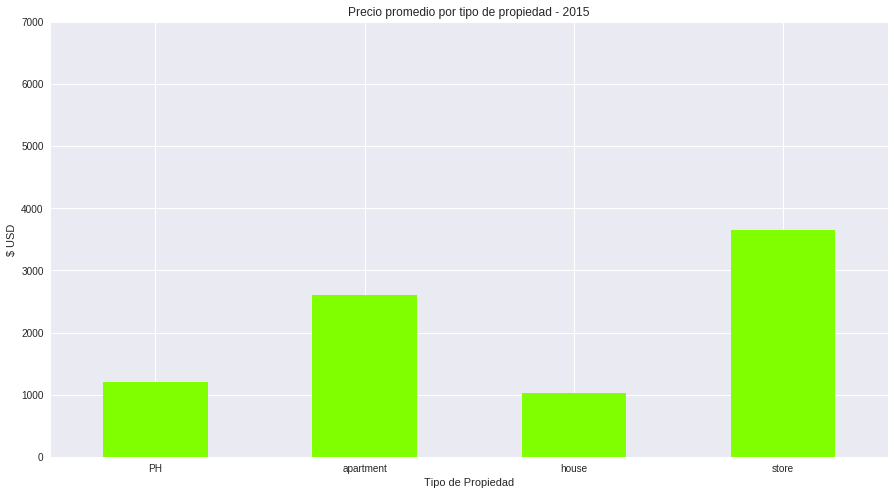

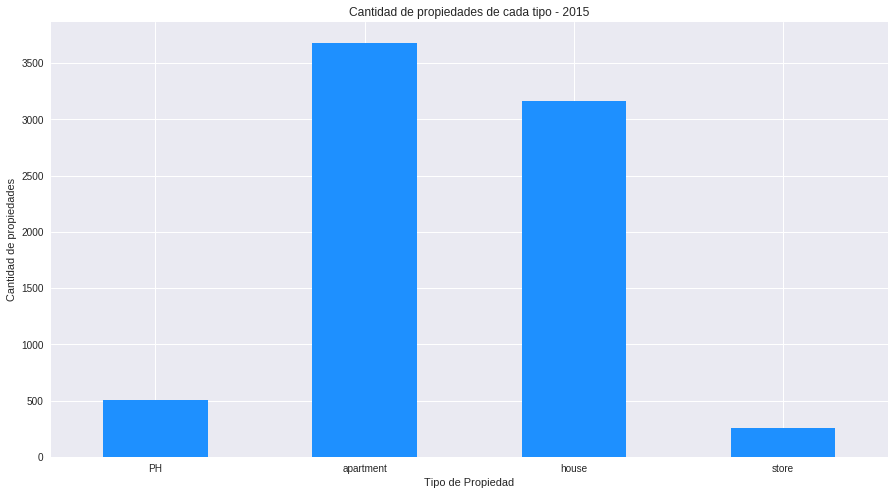

In [43]:
fig = plt.figure(figsize=(12, 6));

ax = average_15.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12), y = 'avg_price',\
                     title = "Precio promedio por tipo de propiedad - 2015",\
                     x = 'type', color = 'chartreuse', rot = 0, legend = False)
ax2 = average_15.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12), y = 'count',\
                      title = "Cantidad de propiedades de cada tipo - 2015",\
                      x = 'type', color = 'dodgerblue', rot = 0, legend = False)
ax2.set_ylabel("Cantidad de propiedades")
ax2.set_xlabel("Tipo de Propiedad")

ax.set_ylim([0,7000])
ax.set_ylabel('$ USD')
ax.set_xlabel('Tipo de Propiedad')

##### Aquí se mantiene el precio de los negocios y baja todo el resto.

#### 2014

In [44]:
grouped = price_by_type.reset_index()
average_14 = grouped[grouped.year == 2014]
average_14

,type,year,avg_price,count
1,PH,2014,1095.142373,245.0
6,apartment,2014,1890.248160,1312.0
12,house,2014,870.078531,1308.0
17,store,2014,2610.832091,141.0


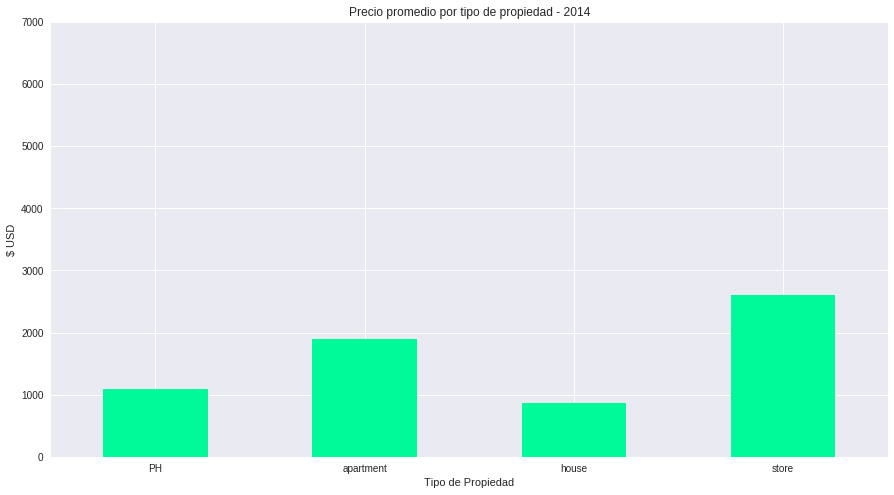

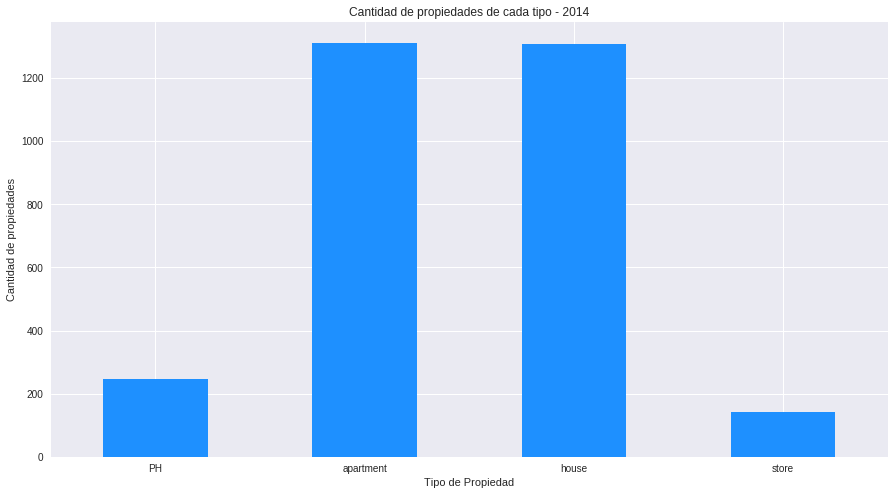

In [45]:
fig = plt.figure(figsize=(12, 6));

ax = average_14.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12), y = 'avg_price',\
                     title = "Precio promedio por tipo de propiedad - 2014",\
                     x = 'type', color = 'mediumspringgreen', rot = 0, legend = False)
ax2 = average_14.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12), y = 'count',\
                      title = "Cantidad de propiedades de cada tipo - 2014",\
                      x = 'type', color = 'dodgerblue', rot = 0, legend = False)
ax2.set_ylabel("Cantidad de propiedades")
ax2.set_xlabel("Tipo de Propiedad")

ax.set_ylim([0,7000])
ax.set_ylabel('$ USD')
ax.set_xlabel('Tipo de Propiedad')

##### Sigue el descenso

#### 2013

In [46]:
grouped = price_by_type.reset_index()
average_13 = grouped[grouped.year == 2013]
average_13

,type,year,avg_price,count
0,PH,2013,1634.962641,25.0
5,apartment,2013,2261.757660,139.0
11,house,2013,877.720219,151.0
16,store,2013,1304.609637,7.0


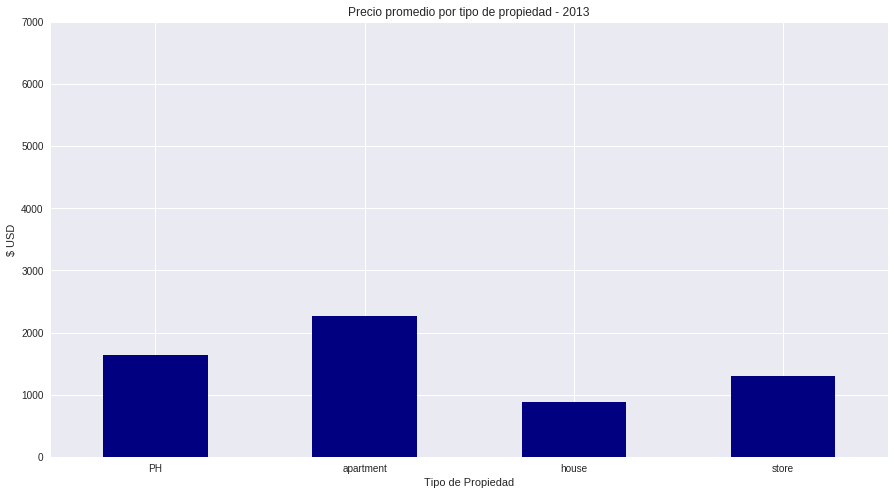

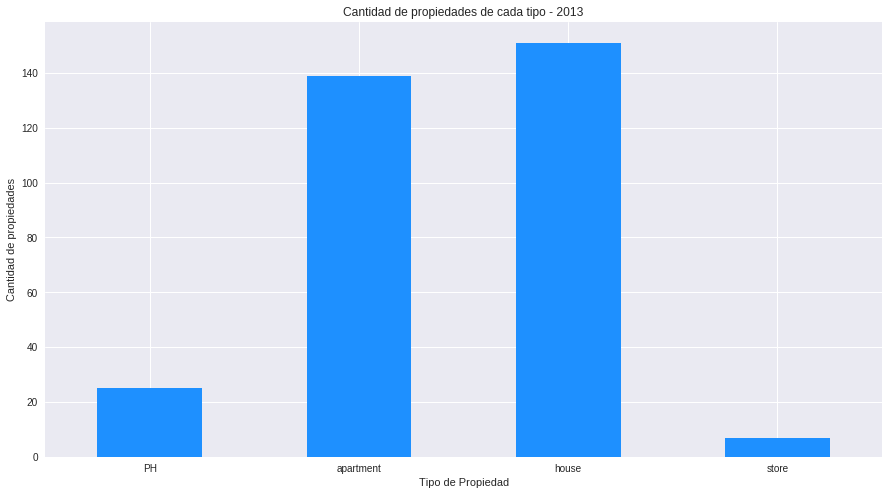

In [47]:
fig = plt.figure(figsize=(12, 6));

ax = average_13.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12), y = 'avg_price',\
                     title = "Precio promedio por tipo de propiedad - 2013",\
                     x = 'type', color = 'navy', rot = 0, legend = False)
ax2 = average_13.plot(kind='bar',figsize=(15,8), grid =True, xticks=range(1,12), y = 'count',\
                      title = "Cantidad de propiedades de cada tipo - 2013",\
                      x = 'type', color = 'dodgerblue', rot = 0, legend = False)
ax2.set_ylabel("Cantidad de propiedades")
ax2.set_xlabel("Tipo de Propiedad")

ax.set_ylim([0,7000])
ax.set_ylabel('$ USD')
ax.set_xlabel('Tipo de Propiedad')

##### Se mantienen con relacion a 2014

### Vemos cómo vario el precio de cada tipo de propiedad a través de los años

#### PHs

In [48]:
phs = grouped[grouped.type.str.contains('PH')]
phs

,type,year,avg_price,count
0,PH,2013,1634.962641,25.0
1,PH,2014,1095.142373,245.0
2,PH,2015,1202.420944,508.0
3,PH,2016,2956.107738,1043.0
4,PH,2017,2585.146306,4106.0


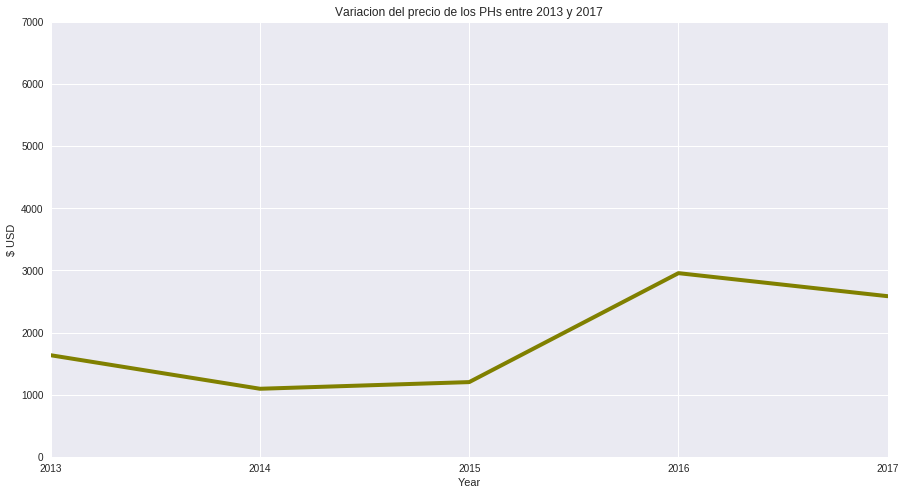

In [49]:
l = [x for x in xrange(2013, 2018)]
ax = phs.plot(kind='line', y = 'avg_price', x = 'year', figsize=(15,8),\
             title = "Variacion del precio de los PHs entre 2013 y 2017",\
             xticks=l, legend = False, color = 'olive', lw = 4)
ax.set_ylabel('$ USD')
ax.set_xlabel('Year')
ax.set_ylim([0,7000])

plt.show()

#### Stores

In [50]:
stores = grouped[grouped.type.str.contains('store')]
stores

,type,year,avg_price,count
16,store,2013,1304.609637,7.0
17,store,2014,2610.832091,141.0
18,store,2015,3653.601389,256.0
19,store,2016,3410.808170,732.0
20,store,2017,6529.084825,2380.0


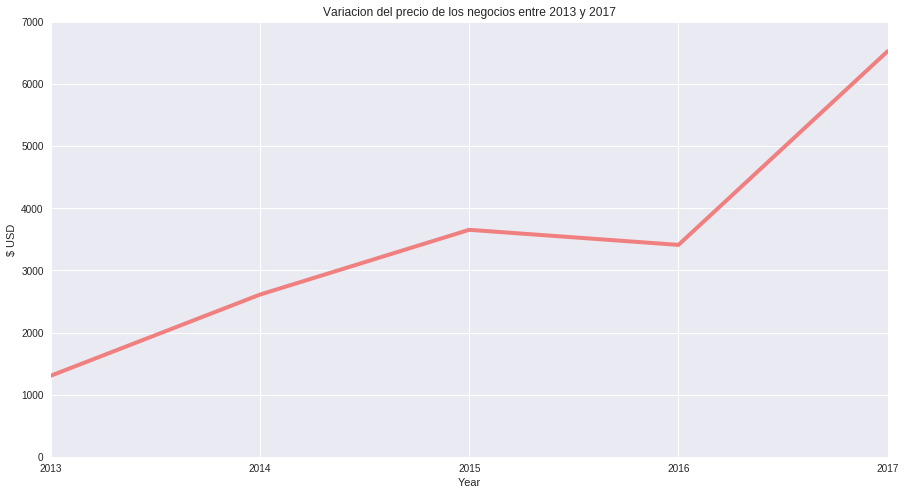

In [51]:
l = [x for x in xrange(2013, 2018)]
ax = stores.plot(kind='line', y = 'avg_price', x = 'year', figsize=(15,8),\
             title = "Variacion del precio de los negocios entre 2013 y 2017",\
             xticks=l, legend = False, color = 'lightcoral', lw = 4)
ax.set_ylabel('$ USD')
ax.set_xlabel('Year')
ax.set_ylim([0,7000])

plt.show()

#### Apartments

In [52]:
apartments = grouped[grouped.type.str.contains('apartment')]
apartments

,type,year,avg_price,count
5,apartment,2013,2261.757660,139.0
6,apartment,2014,1890.248160,1312.0
7,apartment,2015,2597.278122,3682.0
8,apartment,2016,2735.265909,11112.0
9,apartment,2017,3092.455780,42370.0


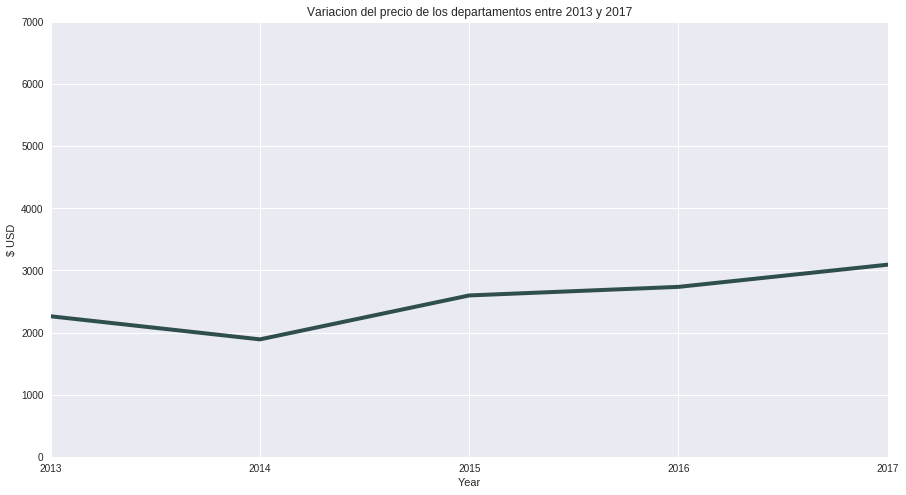

In [53]:
l = [x for x in xrange(2013, 2018)]
ax = apartments.plot(kind='line', y = 'avg_price', x = 'year', figsize=(15,8),\
             title = "Variacion del precio de los departamentos entre 2013 y 2017",\
             xticks=l, legend = False, color = 'darkslategray', lw = 4)
ax.set_ylabel('$ USD')
ax.set_xlabel('Year')
ax.set_ylim([0,7000])

plt.show()

#### Houses

In [54]:
houses = grouped[grouped.type.str.contains('house')]
houses

,type,year,avg_price,count
10,house,2012,659.009009,3.0
11,house,2013,877.720219,151.0
12,house,2014,870.078531,1308.0
13,house,2015,1024.230793,3163.0
14,house,2016,1595.861738,7391.0
15,house,2017,2368.244914,23084.0


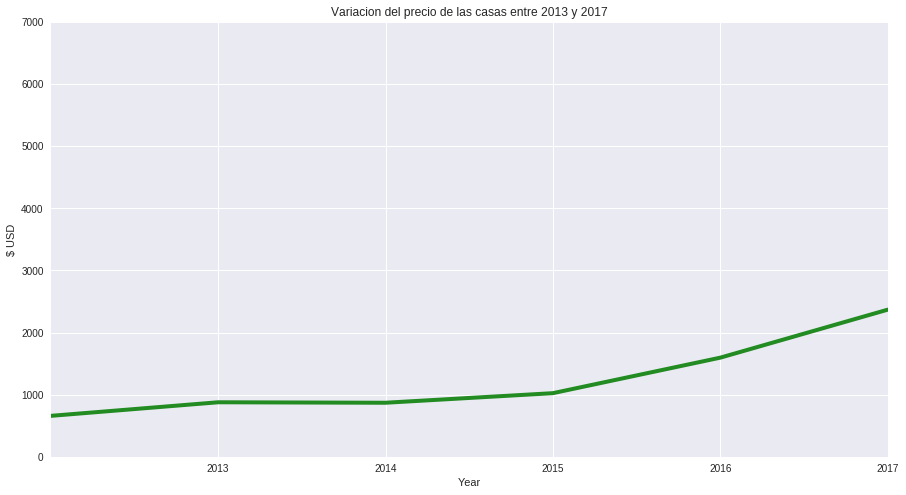

In [55]:
l = [x for x in xrange(2013, 2018)]
ax = houses.plot(kind='line', y = 'avg_price', x = 'year', figsize=(15,8),\
             title = "Variacion del precio de las casas entre 2013 y 2017",\
             xticks=l, legend = False, color = 'forestgreen', lw = 4)
ax.set_ylabel('$ USD')
ax.set_xlabel('Year')
ax.set_ylim([0,7000])

plt.show()

#### Se observa que todas las propiedades tienen crecimiento de precio con el pasar de los años, salvo por los PHs que bajaron de 2016 a 2017. Los negocios son los que más aumentaron. 

#### Gráfico conjunto para comparar año a año el precio de los tipos de propiedad

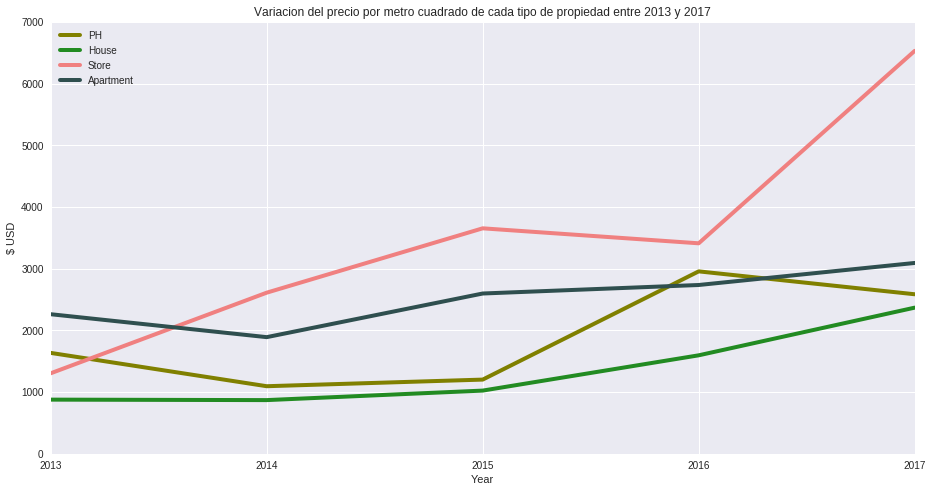

In [56]:
fig = plt.figure(figsize=(12, 6));

ax = fig.add_axes([0,0,1,1]);

phs[['year', 'avg_price']].plot.line(x = 'year', y = 'avg_price', c='olive', label="PH",\
                                    xticks = [i for i in xrange(2013, 2018)], ax = ax, lw = 4);
houses[['year', 'avg_price']].plot.line(x = 'year', y = 'avg_price', c='forestgreen', label="House", ax = ax, lw = 4);
stores[['year', 'avg_price']].plot.line(x = 'year', y = 'avg_price', c='lightcoral', label="Store", ax = ax, lw = 4);
apartments[['year', 'avg_price']].plot.line(x = 'year', y = 'avg_price', c='darkslategray', label="Apartment",\
                                            ax = ax, lw = 4);

plt.title("Variacion del precio por metro cuadrado de cada tipo de propiedad entre 2013 y 2017")
ax.set_ylim([0,7000])
ax.set_ylabel('$ USD')
ax.set_xlabel('Year')
ax.set_xlim([2013, 2017])

ax.legend();

#### El grafico de abajo era para ver como variaba la cantidad de cada tipo de propiedad con el paso del tiempo pero no parecería ayudar mucho

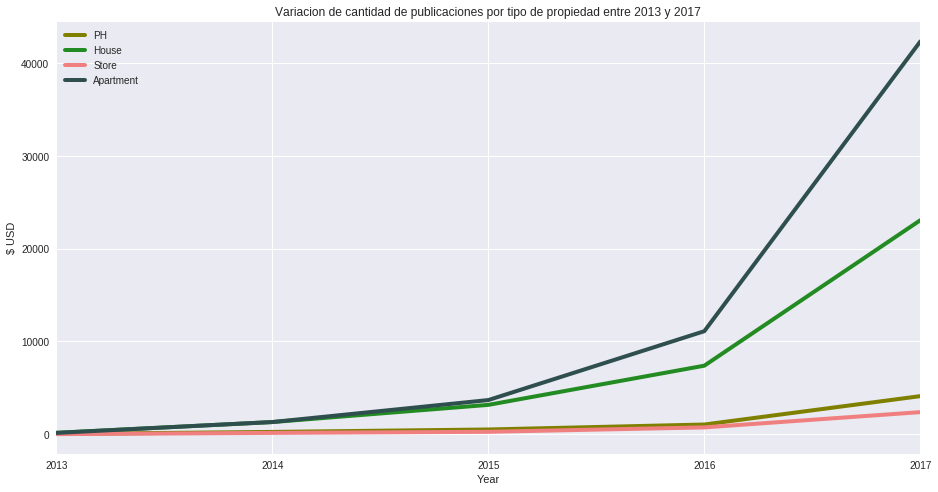

In [57]:
fig = plt.figure(figsize=(12, 6));

ax = fig.add_axes([0,0,1,1]);

phs[['year', 'count']].plot.line(x = 'year', y = 'count', c='olive', label="PH",\
                                    xticks = [i for i in xrange(2013, 2018)], ax = ax, lw = 4);
houses[['year', 'count']].plot.line(x = 'year', y = 'count', c='forestgreen', label="House", ax = ax, lw = 4);
stores[['year', 'count']].plot.line(x = 'year', y = 'count', c='lightcoral', label="Store", ax = ax, lw = 4);
apartments[['year', 'count']].plot.line(x = 'year', y = 'count', c='darkslategray', label="Apartment",\
                                        ax = ax, lw = 4);

plt.title("Variacion de cantidad de publicaciones por tipo de propiedad entre 2013 y 2017")
ax.set_ylabel('$ USD')
ax.set_xlabel('Year')
ax.set_xlim([2013, 2017])

ax.legend();